In [1]:
# note: same thing for REPL
# note: we use this instead of magic because `black` will otherwise fail to format
#
# Enable autoreload to automatically reload modules when they change

from IPython import get_ipython

# do this so that formatter not messed up
ipython = get_ipython()
ipython.run_line_magic("load_ext", "autoreload")
ipython.run_line_magic("autoreload", "2")

# Import commonly used libraries
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# graphics
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# type annotation
import jaxtyping
from jaxtyping import Float32, Int64, jaxtyped
from typeguard import typechecked as typechecker

# more itertools
import more_itertools as mi

# itertools
import itertools
import collections

# tensor manipulation
from einops import rearrange, reduce, repeat

# automatically apply jaxtyping
# %load_ext jaxtyping
# %jaxtyping.typechecker typeguard.typechecked

In [2]:
# Install necessary packages
# If you're running this in a new environment, uncomment the following line:
# !pip install transformer_lens jaxtyping transformers einops

# Import standard libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# Import transformer_lens and other tools
import transformer_lens
from transformer_lens import HookedTransformer

# Import type annotations
from jaxtyping import Float, Int

# Additional imports
import numpy as np
import random
from typing import List, Tuple

# For evaluation and analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# For visualization
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [17]:
import torch
import torch.nn as nn
from transformer_lens import HookedTransformer
import torch.optim as optim
from tqdm import tqdm
import random

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_name = "gpt2-small"
model = HookedTransformer.from_pretrained(model_name)
model.to(device)
model.eval()  # Set the model to evaluation mode

In [19]:
def generate_linearly_separable_sentences(num_samples):
    sentences = []
    labels = []
    for _ in range(num_samples):
        words = ["The", "quick", "brown", "fox"]
        label = random.choice([0, 1])
        if label == 0:
            words.insert(2, "cat")  # Insert "cat" at position 2
        else:
            words.insert(2, "dog")  # Insert "dog" at position 2
        sentence = " ".join(words)
        sentences.append(sentence)
        labels.append(label)
    return sentences, labels


num_samples = 1000
lin_sentences, lin_labels = generate_linearly_separable_sentences(num_samples)

In [20]:
def generate_non_linearly_separable_sentences(num_samples):
    sentences = []
    labels = []
    days = [
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
    for _ in range(num_samples):
        words = ["I", "went", "to", "the", "store", "on"]
        day = random.choice(days)
        words.append(day)
        sentence = " ".join(words)
        # Label: 1 if weekday, 0 if weekend
        if day in ["Saturday", "Sunday"]:
            label = 0
        else:
            label = 1
        sentences.append(sentence)
        labels.append(label)
    return sentences, labels


nonlin_sentences, nonlin_labels = generate_non_linearly_separable_sentences(num_samples)

In [21]:
lin_tokens = model.to_tokens(lin_sentences, prepend_bos=False).to(device)
nonlin_tokens = model.to_tokens(nonlin_sentences, prepend_bos=False).to(device)

In [22]:
lin_labels = torch.tensor(lin_labels).float().to(device)
nonlin_labels = torch.tensor(nonlin_labels).float().to(device)

In [23]:
# For Dataset 1
with torch.no_grad():
    lin_logits, lin_cache = model.run_with_cache(lin_tokens)

# For Dataset 2
with torch.no_grad():
    nonlin_logits, nonlin_cache = model.run_with_cache(nonlin_tokens)

In [51]:
n_layers = model.cfg.n_layers

In [52]:
# layer = 7  # You can experiment with different layers
position = 2  # Position where "cat" or "dog" appears

In [ ]:
# Initialize a list to store residuals from each layer
lin_residuals = []

# Iterate over each layer
for layer in range(n_layers + 1):  # Including input embedding (layer 0)
    # Access the residual stream at the specified position
    if layer == 0:
        resid = lin_cache["resid_pre", 0][:, position, :].detach()
    else:
        resid = lin_cache["resid_post", layer - 1][:, position, :].detach()
    lin_residuals.append(resid)

# Stack residuals: Shape -> (n_layers + 1, batch_size, d_model)
lin_residuals = torch.stack(lin_residuals)

In [53]:
nonlin_position = -1  # Last token position
nonlin_residuals = []

for layer in range(n_layers + 1):
    if layer == 0:
        resid = nonlin_cache["resid_pre", 0][:, nonlin_position, :].detach()
    else:
        resid = nonlin_cache["resid_post", layer - 1][:, nonlin_position, :].detach()
    nonlin_residuals.append(resid)

nonlin_residuals = torch.stack(nonlin_residuals)

In [43]:
class LinearProbe(nn.Module):
    def __init__(self, d_model):
        super(LinearProbe, self).__init__()
        self.linear = nn.Linear(d_model, 1)

    def forward(self, x):
        return self.linear(x)

In [54]:
def train_linear_probes(residuals, labels, epochs=5):
    """
    Train a linear probe for each layer's residuals.

    Args:
        residuals: Tensor of shape (n_layers, batch_size, d_model)
        labels: Tensor of shape (batch_size,)
        epochs: Number of training epochs

    Returns:
        probes: List of trained LinearProbe instances
        losses: List of training losses for each layer
    """
    n_layers = residuals.size(0)
    d_model = residuals.size(2)
    batch_size = residuals.size(1)

    probes = []
    losses = []

    for layer in range(n_layers):
        probe = LinearProbe(d_model).to(device)
        optimizer = optim.Adam(probe.parameters(), lr=1e-3)
        criterion = nn.BCEWithLogitsLoss()

        # Get residuals for this layer: Shape (batch_size, d_model)
        layer_residuals = residuals[layer]

        # Training loop
        for epoch in range(epochs):
            probe.train()
            optimizer.zero_grad()
            outputs = probe(layer_residuals).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        probes.append(probe)
        losses.append(loss.item())

    return probes, losses


def evaluate_probes(probes, residuals, labels):
    """
    Evaluate the linear probes on the residuals.

    Args:
        probes: List of LinearProbe instances
        residuals: Tensor of shape (n_layers, batch_size, d_model)
        labels: Tensor of shape (batch_size,)

    Returns:
        accuracies: List of accuracies for each layer
    """
    n_layers = residuals.size(0)
    accuracies = []

    for layer in range(n_layers):
        probe = probes[layer]
        layer_residuals = residuals[layer]
        probe.eval()
        with torch.no_grad():
            outputs = probe(layer_residuals).squeeze()
            predictions = torch.sigmoid(outputs) > 0.5
            accuracy = (predictions == labels.byte()).float().mean()
            accuracies.append(accuracy.item())
    return accuracies

In [55]:
epochs = 5

# Train probes
lin_probes, lin_losses = train_linear_probes(lin_residuals, lin_labels, epochs=epochs)

# Evaluate probes
lin_accuracies = evaluate_probes(lin_probes, lin_residuals, lin_labels)

In [56]:
# Train probes
nonlin_probes, nonlin_losses = train_linear_probes(
    nonlin_residuals, nonlin_labels, epochs=epochs
)

# Evaluate probes
nonlin_accuracies = evaluate_probes(nonlin_probes, nonlin_residuals, nonlin_labels)

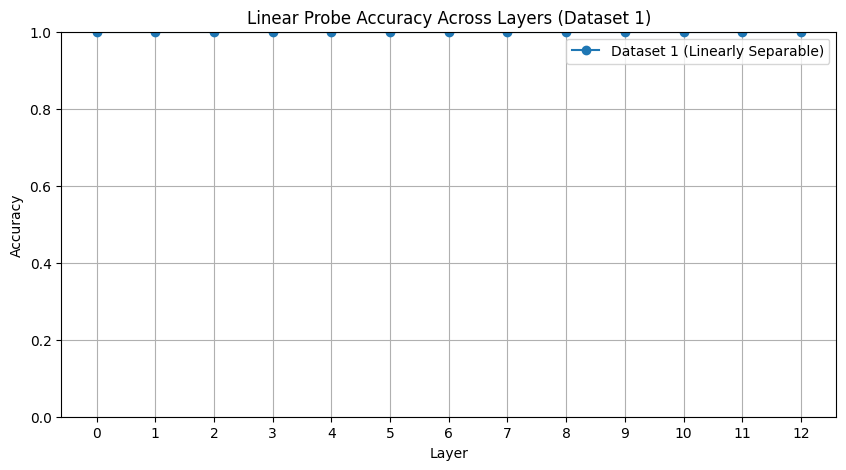

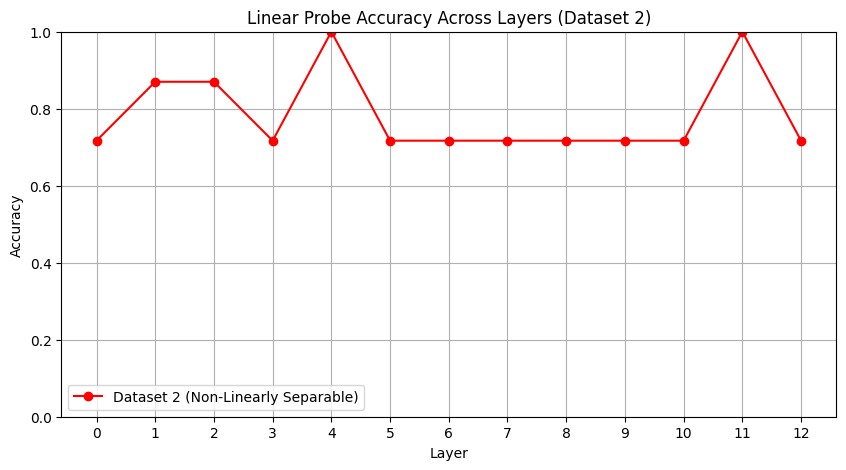

In [57]:
import matplotlib.pyplot as plt

layers = list(range(n_layers + 1))

# For Dataset 1
plt.figure(figsize=(10, 5))
plt.plot(layers, lin_accuracies, marker="o", label="Dataset 1 (Linearly Separable)")
plt.title("Linear Probe Accuracy Across Layers (Dataset 1)")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.xticks(layers)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

# For Dataset 2
plt.figure(figsize=(10, 5))
plt.plot(
    layers,
    nonlin_accuracies,
    marker="o",
    color="red",
    label="Dataset 2 (Non-Linearly Separable)",
)
plt.title("Linear Probe Accuracy Across Layers (Dataset 2)")
plt.xlabel("Layer")
plt.ylabel("Accuracy")
plt.xticks(layers)
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

In [48]:
class NonLinearProbe(nn.Module):
    def __init__(self, d_model):
        super(NonLinearProbe, self).__init__()
        self.fc1 = nn.Linear(d_model, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

In [49]:
nonlin_probe = LinearProbe(d_model).to(device)
optimizer = optim.Adam(nonlin_probe.parameters(), lr=1e-3)

# Training loop
for epoch in range(epochs):
    nonlin_probe.train()
    optimizer.zero_grad()
    outputs = nonlin_probe(nonlin_residual_stream).squeeze()
    loss = criterion(outputs, nonlin_labels)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 0.5570
Epoch 11/100, Loss: 0.1772
Epoch 21/100, Loss: 0.0573
Epoch 31/100, Loss: 0.0295
Epoch 41/100, Loss: 0.0193
Epoch 51/100, Loss: 0.0146
Epoch 61/100, Loss: 0.0118
Epoch 71/100, Loss: 0.0100
Epoch 81/100, Loss: 0.0087
Epoch 91/100, Loss: 0.0077


In [50]:
nonlin_probe.eval()
with torch.no_grad():
    outputs = nonlin_probe(nonlin_residual_stream).squeeze()
    predictions = torch.sigmoid(outputs) > 0.5
    accuracy = (predictions == nonlin_labels.byte()).float().mean()
    print(f"Linear Probe Accuracy on Dataset 2: {accuracy.item() * 100:.2f}%")

Linear Probe Accuracy on Dataset 2: 100.00%
